#  OCR(Optical Character Recognition)
OCR(광학 문자 인식)은 문자를 읽는 기술로써 산업적으로 매우 유용한 기술입니다. 이번 노드를 통해서 얻는것은:
1. OCR의 과정을 이해
2. 문자인식 결과의 표현방식을 이해
3. 파이썬을 통해 OCR 구현

OCR이 문자를 인식하는 과정을 이해하기 전에 사람이 문자를 읽으려면 어떤 과정을 거치는지 알아야 이해가 편합니다.
1. 문자를 인식
2. 인식한 문자를 해독

이 과정을 OCR에 대입을 하면
1. 문자를 Detection
2. 어떤 문자인지 판독(Recognition)

정말 기계가 사진속의 글자를 잘 읽을수 있는지 구글의 클라우드 기반 OCR API를 사용해 봅니다. 이 서비스는 유료이지만 처음 등록하면 무료로 사용할 수 있는 $300 크레딧을 주어서 바로 비용이 청구될 걱정은 없지만 결제수단이 없거나 번거롭다고 느낀다면 이 스텝은 읽어만 봐도 무방합니다.

___________________________


# Google OCR API

In [ ]:
# step 1: 구글의 파이썬 API 인터페이스 모듈을 아래와 같이 설치합니다. 사용하는 클라우드 환경에는 이미 설치가 되어있습니다.
! pip install -upgrade google-api-python-client
! pip install google-cloud-vision

In [ ]:
# step 2: Google Cloud Vision API 사용
# https://kimchangheon.tistory.com/166 의 설명을 참고해서 서비스 계정 및 인증키를 생성합니다.
# 브라우저에서 다운로드한 인증키는 `my_google_api_key.json`이라는 파일명으로 변경합니다.
# cloud jupyter를 열고 my_google_api_key.json 파일을 ~/aiffel/ocr_python 디렉토리에 업로드 해줍니다.

In [ ]:
# step 3: API 사용 테스트
# API를 활용하는 코드는 아래와 같습니다. 사용할 이미지를 cloud jupyter를 이용하여 업로드후 경로를 지정해 줍니다.
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [ ]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.
# (예시) path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
path = # [[YOUR IMAGE FILE PATH]]   

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)


___________________________

# 모델이 문자를 읽는 과정
구글 API에서는 문자의 영역을 사각형으로 표현하고 우측에 block과 paragraph로 구분해서 인식결과를 나타내고 있습니다. 문자 모델은 보통 두 단계로 이루어 집니다.
1. Text Detection(문자검출): 입력받은 사진 속에서 문자의 위치를 찾아냅니다
2. Text Recognition(문자인식): 찾은 문자 영역으로부터 문자를 읽어냅니다

예를 들어 카카오의 OCR모델은 먼저 문자가 있는 영역의 정보(coord, Text Recognition)을 찾아내고, 각 영역에서 문자를 인식합니다. 특히 문자의 영역을 표현하는 방법으로 사각형의 네 꼭짓점 좌표를 알려주는 방법 뿐만아니라 다른 도형이나 표현 방법을 사용할 수도 있습니다. 예를 들자면:
1. 축에 정렬된 사각형인 bounding box
2. 돌아간 사각형 oriented bounding box
3. 자유로운 사각형인 quadrangle
4. 다각형인 polygon
5. pixel 수준으로 영역을 표현한 mask

# Text Detection 문자검출
사진 속 문자를 찾아내는 최근의 딥러닝 모델은 일반적인 object dectection(객체인식)방법으로 접근합니다. 딥러닝 기반 객체 검출 방법에는 regression(회귀)방식이나 segmentation방식이 있습니다. regression은 기준으로 하는 박스 대비 문자의 박스가 얼마나 차이가 나는지를 학습합니다. segmentation은 픽셀 단위로 해당 픽셀이 문자를 표현하는지를 분류하는 문제(pixel-wise classification)이라고 볼 수 있습니다.

문자는 일반적인 객체와 다른 두가지 특성을 가지고 있습니다.
1. 일반적인 객체는 물체에 따라서 크기가 일정한 특징을 가집니다. 하지만 문자는 영역과 배치가 자유로워 문자를 검출하기 위한 설정이 필요합니다.
2. 객체는 물체 간 거리가 충분히 확보되는 데에 반해 글자는 매우 촘촘하게 배치되어 있습니다.

문자는 문자,단어,줄,단락 단위 등으로 사진 속에서 검출해낼 수 있습니다.

# Text Recognition 문자인식
문자 인식은 사진 속에서 문자를 검출해내는 검출 모델이 영역을 잘라서 주면 그 영역에 어떤 글자가 포함되어 있는지 읽어내는 과정입니다. 이 과정으 이미지 문제보다는 자연어 처리에서 많은 영감을 받았습니다. 그 이유는 이미지 내의 문자 인식 모델의 기본적인 방법 중 하나가 바로 CNN과 RNN을 결합한 CRNN모델이기 때문입니다. 이미지 내의 텍스트와 연관된 특징을 CNN을 통해 추출한 후에 스텝 단위의 문자 정보를 RNN으로 인식하는 것입니다.
![CRNN.png](../Exploration/CRNN.png)
이렇게 검출 결과로부터 인식 모델을 통해 문자를 인식하고 나면 구글 API의 결과처럼 사진 속 영역에 표시하고 그 영역에 어떤 문자가 적혀있는지 알 수 있는 OCR 시스템이 됩니다.

detection, recognition 모델만으로는 단어별 문자를 인식할 수는 있어도 사람이 의미를 가지고 읽어내는 문단 혹은 블록 정보를 어떻게 구글 OCR API는 해결했을까요? 두가지 방법을 생각해 볼 수 있습니다.
1. 이미지 내에서 검출된 단어 영역의 위치정보를 기준으로 분리를 함
2. x,y축으로 L2 Distance가 일정 이내인 단어 또는 문자들의 그룹을 만들어 단락으로 만듦

https://tv.naver.com/v/4578167


https://www.youtube.com/watch?v=ckRFBl_XWFg

# keras-ocr
텐서플로우를 기반으로 모델을 구현해서 OCR을 직접 돌려봅니다. `keras-ocr`은 텐서플로우의 케라스 api를 기반으로 이미지 속 문자를 읽는 end-to-end ocr을 할 수 있게 해줍니다. 공식 문서에도 나와있듯 검출 모델로 CRAFT(Character Region Awareness for Text Detection)을 사용하고, 인식 모델로는 CRNN을 사용합니다.

In [2]:
! pip list| grep kears-ocr

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


`keras-ocr`과 인식 결과의 시각화를 위한 `matplotlib.pyplot`를 불러옵니다. `keras_ocr.pipeline.Pipeline()`은 인식을 위한 파이프라인을 생성하는데 이때 초기화 과정에서 미리 학습된 모델의 가중치를 불러옵니다. 검출기와 인식기를 위한 가중치 하나씩을 불러오겠지요.

In [4]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [5]:
# 만들어둔 파이프라인의 recognize()에 이미지를 몇 개 넣어줍니다.

# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
  'https://source.unsplash.com/M7mu6jXlcns/640x460',
  'https://source.unsplash.com/6jsp4iHc8hI/640x460',
  'https://source.unsplash.com/98uYQ-KupiE',
  'https://source.unsplash.com/j9JoYpaJH3A',
  'https://source.unsplash.com/eBkEJ9cH5b4'
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


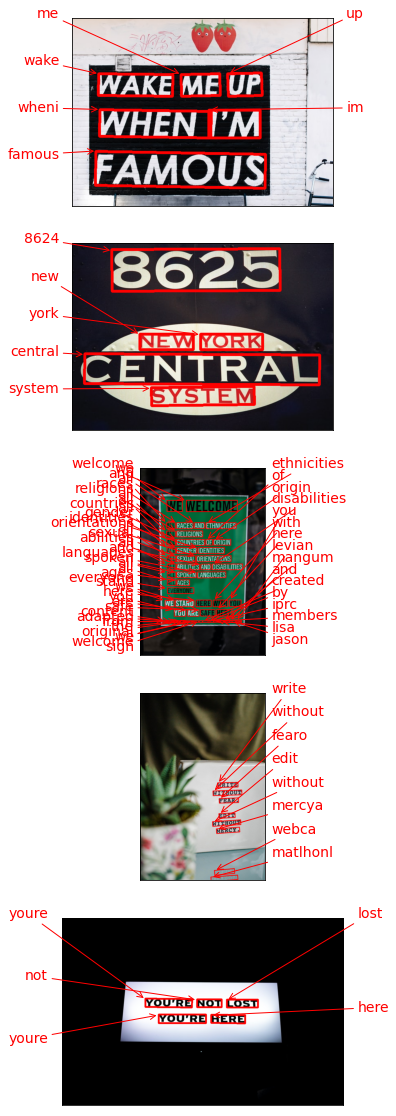

In [6]:
# 인식된 결과를 pyplot으로 시각화 합니다.
# 내부적으로 recognize()는 검출기와 인식기를 두고, 검출기로 바운딩 박스를 검출한 뒤, 인식기가 각 박스로부터 문자를 인식하는 과정을 거치도록 합니다.

# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

# Tesseract OCR
이번에는 테서랙트 라이브러리로 이미지에서 문자를 인식해 보겠습니다.

In [11]:
# 1) 테서랙트 설치
! sudo apt install tesseract-ocr --yes
! sudo apt install libtesseract-dev --yes

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  liblept5 libopenjp2-7 libtesseract4 tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  liblept5 libopenjp2-7 libtesseract4 tesseract-ocr tesseract-ocr-eng
  tesseract-ocr-osd
0 upgraded, 6 newly installed, 0 to remove and 0 not upgraded.
Need to get 7,031 kB of archives.
After this operation, 22.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libopenjp2-7 amd64 2.3.0-2build0.18.04.1 [145 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 liblept5 amd64 1.75.3-3 [929 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libtesseract4 amd64 4.00~git2288-10f4998a-2 [1,163 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:5 http://archive.ubuntu.c

In [13]:
# 2) 테서랙트 파이선 wrapper 설치하기
# Pytesseract는 OS에 설치된 테서랙트를 파이썬에서 쉽게 사용할 수 있도록 해주는 래퍼 라이브러리 입니다.
# 파이썬 내에서 컴퓨터에 설치된 테서랙트 엔진의 기능을 바로 쓸 수 있도록 해줍니다.

! pip list | grep pytesseract

pytesseract                   0.3.7
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [16]:
# 3) 테서랙트로 문자 검출하고 이미지 자르기 (detection)
# 테서랙트를 사용하면 한 번에 이미지 내의 문자 검출과 인식을 할 수 있는데, OCR이 이뤄지는 전체 과정을 직접 거쳐보기 위해 검출을 먼저 합니다.

import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/test_image.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png
/aiffel/aiffel/ocr_python/0002.png
/aiffel/aiffel/ocr_python/0003.png
/aiffel/aiffel/ocr_python/0004.png
/aiffel/aiffel/ocr_python/0005.png
/aiffel/aiffel/ocr_python/0006.png
/aiffel/aiffel/ocr_python/0007.png
/aiffel/aiffel/ocr_python/0008.png


위에서 구현한 `crop_word_regions()` 함수는 선택한 테스트 이미지를 받아서, 문자 검출을 진행한 후, 검출된 문자 영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴하는 함수입니다. 기본저으로 `pytesseract.image_to_data()`를 사용합니다. 파이썬에서 편하게 사용하기 위해서 pytesseract의 output을 사용해서 결과값의 형식을 딕셔너리 형식으로 설정해 주게 됩니다. 이렇게 인식된 결과는 바운딩 박스의 left,top,width,height정보를 가지게 됩니다. 이 바운딩 박스를 사용해 이미지의 문자 영역들을 파이썬 PIL 또는 opencv 라이브러리를 사용해 잘라서 `cropped_image_path_list`에 담아 리턴했습니다.

사진속의 문자들에 한국어가 표시가 되어있다면 lang-'kor'로 바꿔야 하는데 그전에 테서랙트의 언어팩을 설치해야 정상으로 작동합니다.

`! sudo apt install tesseract-ocr-kor`

In [78]:
! sudo apt install tesseract-ocr-kor

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tesseract-ocr-kor
0 upgraded, 1 newly installed, 0 to remove and 0 not upgraded.
Need to get 1,050 kB of archives.
After this operation, 1,693 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-kor all 4.00~git24-0e00fe6-1.2 [1,050 kB]
Fetched 1,050 kB in 1s (1,479 kB/s)         
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline

78Selecting previously unselected package tesseract-ocr-kor.
(Reading database ... 73165 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-kor_4.00~git24-0e00fe6-1.2_all.deb ...
7Progress: [  0%] [..................

In [17]:
# 4) 테서랙트로 잘린 이미지에서 단어 인식
# 검출된 바운딩 박스 별로 잘린 이미지를 넣어주면 영역별 텍스트가 결과값으로 나오는 image_to_string()을 사용합니다.

def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

—Lwe SN



so

oe Si

s

eae

Ve

\maeie

Done


내가 넣은 이미지의 글자들이 제대로 인식이 되었는지 확인해 봅니다.
![test_image.png](../ocr_python/test_image.png)

file_list: ['0001.png', '0007.png', '0003.png', '0002.png', '0004.png', '0000.png', '0006.png', 'test_image.png', '0005.png', '0008.png']


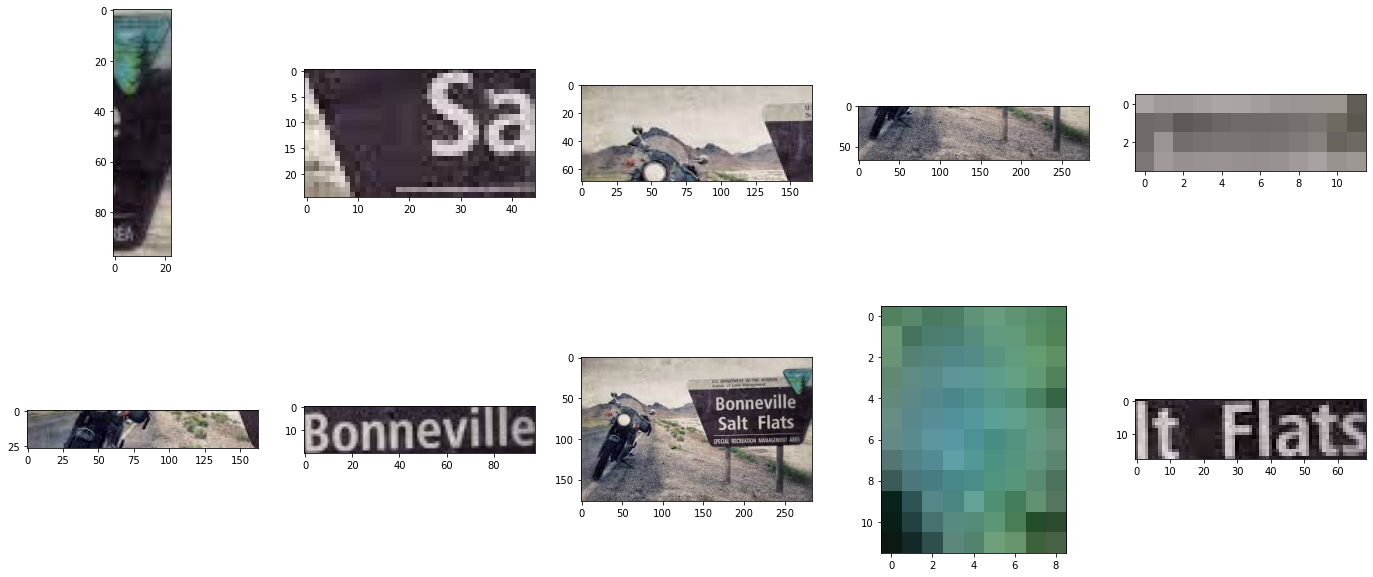

In [44]:
import os

dir_path = os.getenv('HOME')+'/aiffel/ocr_python'
file_list = os.listdir(dir_path)

print ("file_list: {}".format(file_list))

import matplotlib.pyplot as plt
import matplotlib.image as img

#Set figsize here
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24,10))

# flatten axes for easy iterating
for i, ax in enumerate(axes.flatten()):
  image = img.imread(dir_path+'/'+file_list[i])
  ax.imshow(image)
plt.show()

fig.tight_layout()

# 프로젝트 : 다양한 OCR모델 비교

file_list: ['test3.jpeg', 'test1.jpeg', 'test2.jpeg']


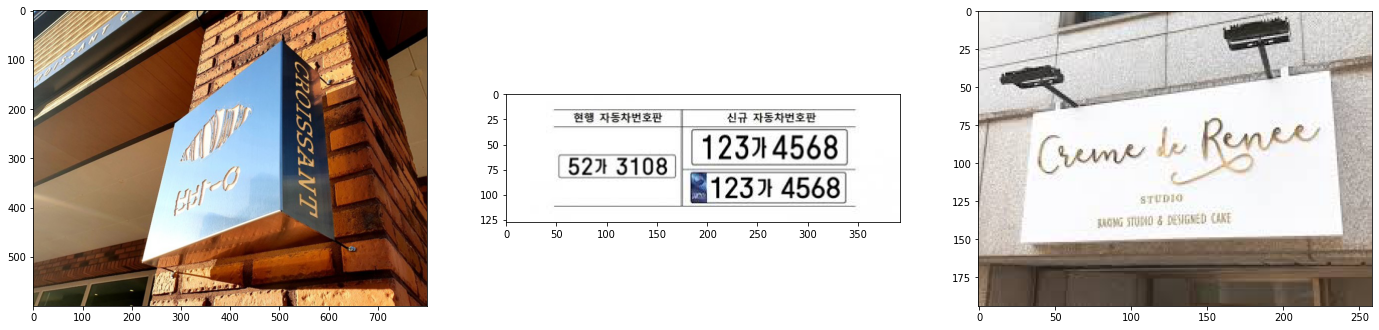

In [45]:
import os

dir_path = os.getenv('HOME')+'/aiffel/ocr_python/test'
file_list = os.listdir(dir_path)

print ("file_list: {}".format(file_list))

import matplotlib.pyplot as plt
import matplotlib.image as img

#Set figsize here
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24,10))

# flatten axes for easy iterating
for i, ax in enumerate(axes.flatten()):
  image = img.imread(dir_path+'/'+file_list[i])
  ax.imshow(image)
plt.show()

fig.tight_layout()

세가지 사진을 준비해 봤습니다. 첫번째 사진은 croissant이라는 단어가 수직으로 있을때 잘 인식을 할 수 있는지, 두번째는 한국어를 잘 인식을 하는지, 그리고 마지막 세번째는 필기체 혹은 다른 글씨체도 인식이 가능한지를 알아보기 위해 위 사진들로 준비했습니다.

# keras

In [46]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [72]:

# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_paths = [
       '/aiffel/aiffel/ocr_python/test/test1.png',
    '/aiffel/aiffel/ocr_python/test/test2.png',
    '/aiffel/aiffel/ocr_python/test/test3.png'
    
    ]

images = [ keras_ocr.tools.read(path) for path in image_paths]

In [73]:
prediction_groups = [pipeline.recognize([path]) for path in image_paths]

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


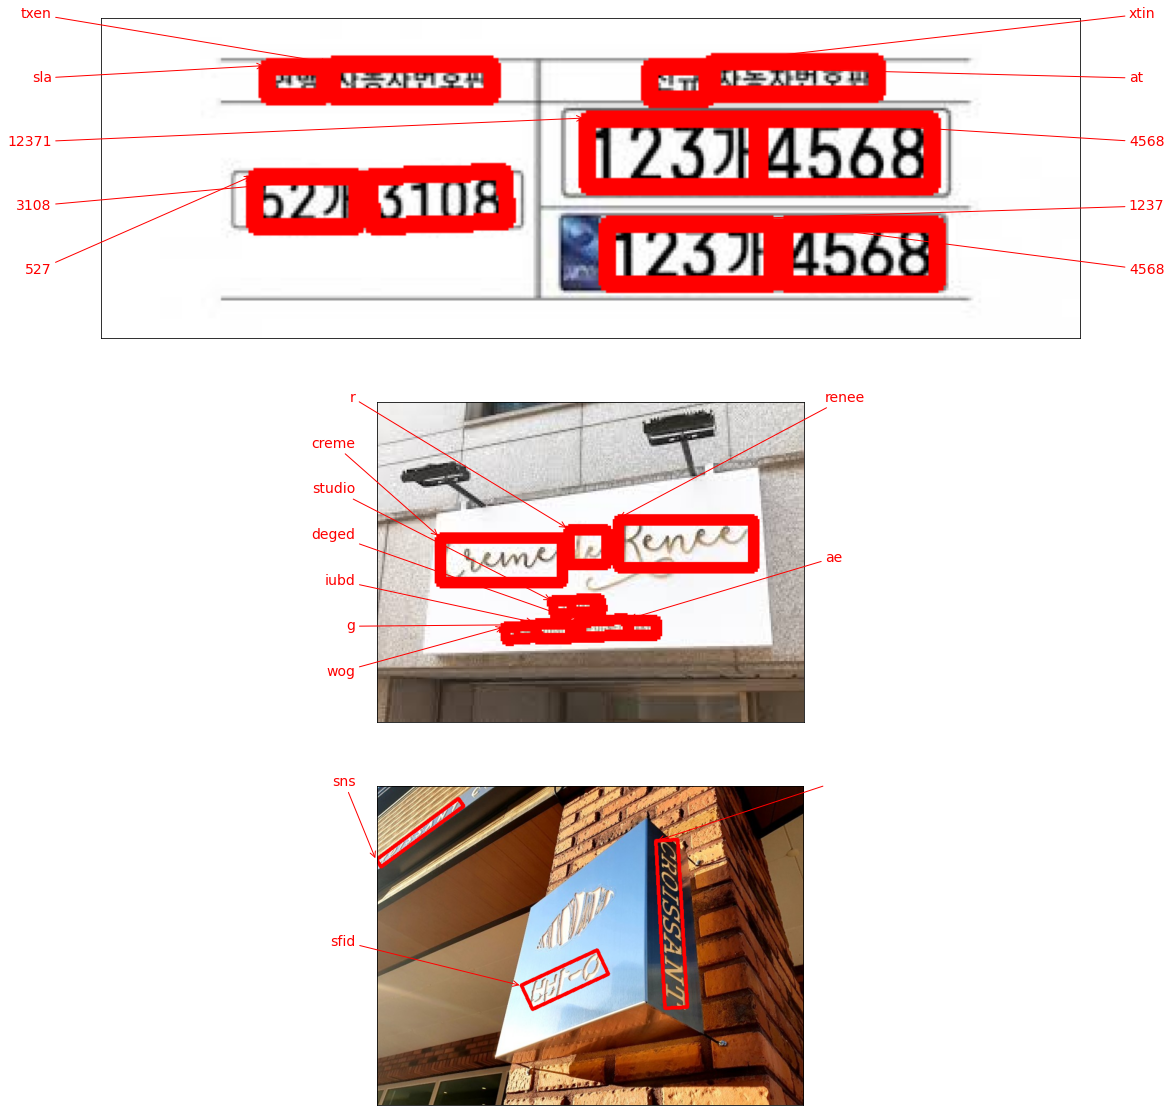

In [74]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

In [75]:
def draw_tesseract(image_path,ax):
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            draw_box(left,top,width,height, ax)

In [79]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python/test'
img_file_path = work_dir + '/test1.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)


/aiffel/aiffel/ocr_python/test/0000.png
/aiffel/aiffel/ocr_python/test/0001.png
/aiffel/aiffel/ocr_python/test/0002.png
/aiffel/aiffel/ocr_python/test/0003.png
/aiffel/aiffel/ocr_python/test/0004.png
/aiffel/aiffel/ocr_python/test/0005.png
/aiffel/aiffel/ocr_python/test/0006.png
/aiffel/aiffel/ocr_python/test/0007.png
/aiffel/aiffel/ocr_python/test/0008.png
/aiffel/aiffel/ocr_python/test/0009.png
/aiffel/aiffel/ocr_python/test/0010.png
/aiffel/aiffel/ocr_python/test/0011.png
/aiffel/aiffel/ocr_python/test/0012.png
/aiffel/aiffel/ocr_python/test/0013.png


In [80]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    text_list=[]
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        text_list.append(recognized_data['text'])
    print("Done")
    return text_list

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

Done


['os\n\x0c',
 'A}\n\x0c',
 '=\n\x0c',
 'AP\n\x0c',
 'oer\n\x0c',
 'Cl ef\n\x0c',
 'A\n\x0c',
 '=\n\x0c',
 'AP\n\x0c',
 '712 er\n\x0c',
 '173714568\n\x0c',
 '527 310\n\x0c',
 '8\n\x0c',
 '\x0c']

In [81]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python/test'
img_file_path = work_dir + '/test2.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)


/aiffel/aiffel/ocr_python/test/0000.png


In [82]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    text_list=[]
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        text_list.append(recognized_data['text'])
    print("Done")
    return text_list

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

Done


['=\n\x0c']

In [86]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python/test'
img_file_path = work_dir + '/test3.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/test/0000.png


SystemError: tile cannot extend outside image

# 결과 분석과 결론 제시
저는 일단 일상생활에서 가장 많이 볼 수 있는 것들 위주로 생각을 해 보았습니다. 특히 간판이나 번호판을 생각을 해 보았는데 특히 차량 번호판 같은 경우 차량의 번호판을 ocr로 인식해서 추적하고자 하는 차량에 태그를 설정해서 어느 특정 시점의 행적들을 유추하는 서비스같은걸 해 볼 수 있을거 같습니다. 또한 간판같은 경우 ocr로 상호명을 입력을 받고 사용자가 원하는 음식 카테고리를 입력하면 입력된 문자열을 기준으로 가장 가까운 음식점을 추천해 주는 서비스도 가능할거 같습니다. 다만 이를 위해서는 모델들이 문자를 명확하게 인식을 할줄 알아야 할 것 입니다. 위 결과를 보면 알겠지만, keras나 테서랙트 모두 그다지 좋은 성능을 내고있지는 못합니다. 특히 테서랙트는 아예 쓰지 않는것을 고려해야 할 정도입니다. google ocr api를 사용해 보지는 않았지만, 같은 해커톤 팀원에게 결과를 봤을때는 위 2모델보다는 훨씬 월등한 성능을 보여줬습니다. 다만 이 api가 유료인 점이 문제일거 같습니다. 따라서 서비스의 규모와 타겟에 따라 달라지겠지만, 서비스의 규모가 크지 않다면 keras 규모가 크다면 google로 사용할것 같습니다.

# 회고
사용한 사진을 모두 시각화 해보고 싶었지만, 사용한 3개의 사진중 3번째 사진이 시각화가 안되는 부분이 제일 아쉬웠습니다. ocr를 공부하면서 정말 많은 분야에 사용이 가능하겠구나 라고 생각을 했습니다. 세상의 모든 지식이 대부분은 글로써 전달이 되고 있는데 ocr을 사용해서 요약을 하는 모델이나 번역을 하는 모델을 추가적으로 사용한다면 더이상 언어 혹은 시간의 제약때문에 지식의 습득을 하지 못하는일은 일어나지 않을거 같습니다.